<a href="https://colab.research.google.com/github/dyjdlopez/demo-hybrid-quantum-nn/blob/main/demo_hqn_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Quantum Neural Networks Part 1: Quantum Neural Networks with Pennylane



In [258]:
!pip install nvidia-cusparse-cu12 nvidia-cublas-cu12 nvidia-cuda-runtime-cu12 custatevec_cu12
!pip install pennylane pennylane-lightning-gpu

In [259]:
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer

import torch

from pennylane import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## 1. Importing the Data (Two-Moon Dataset)

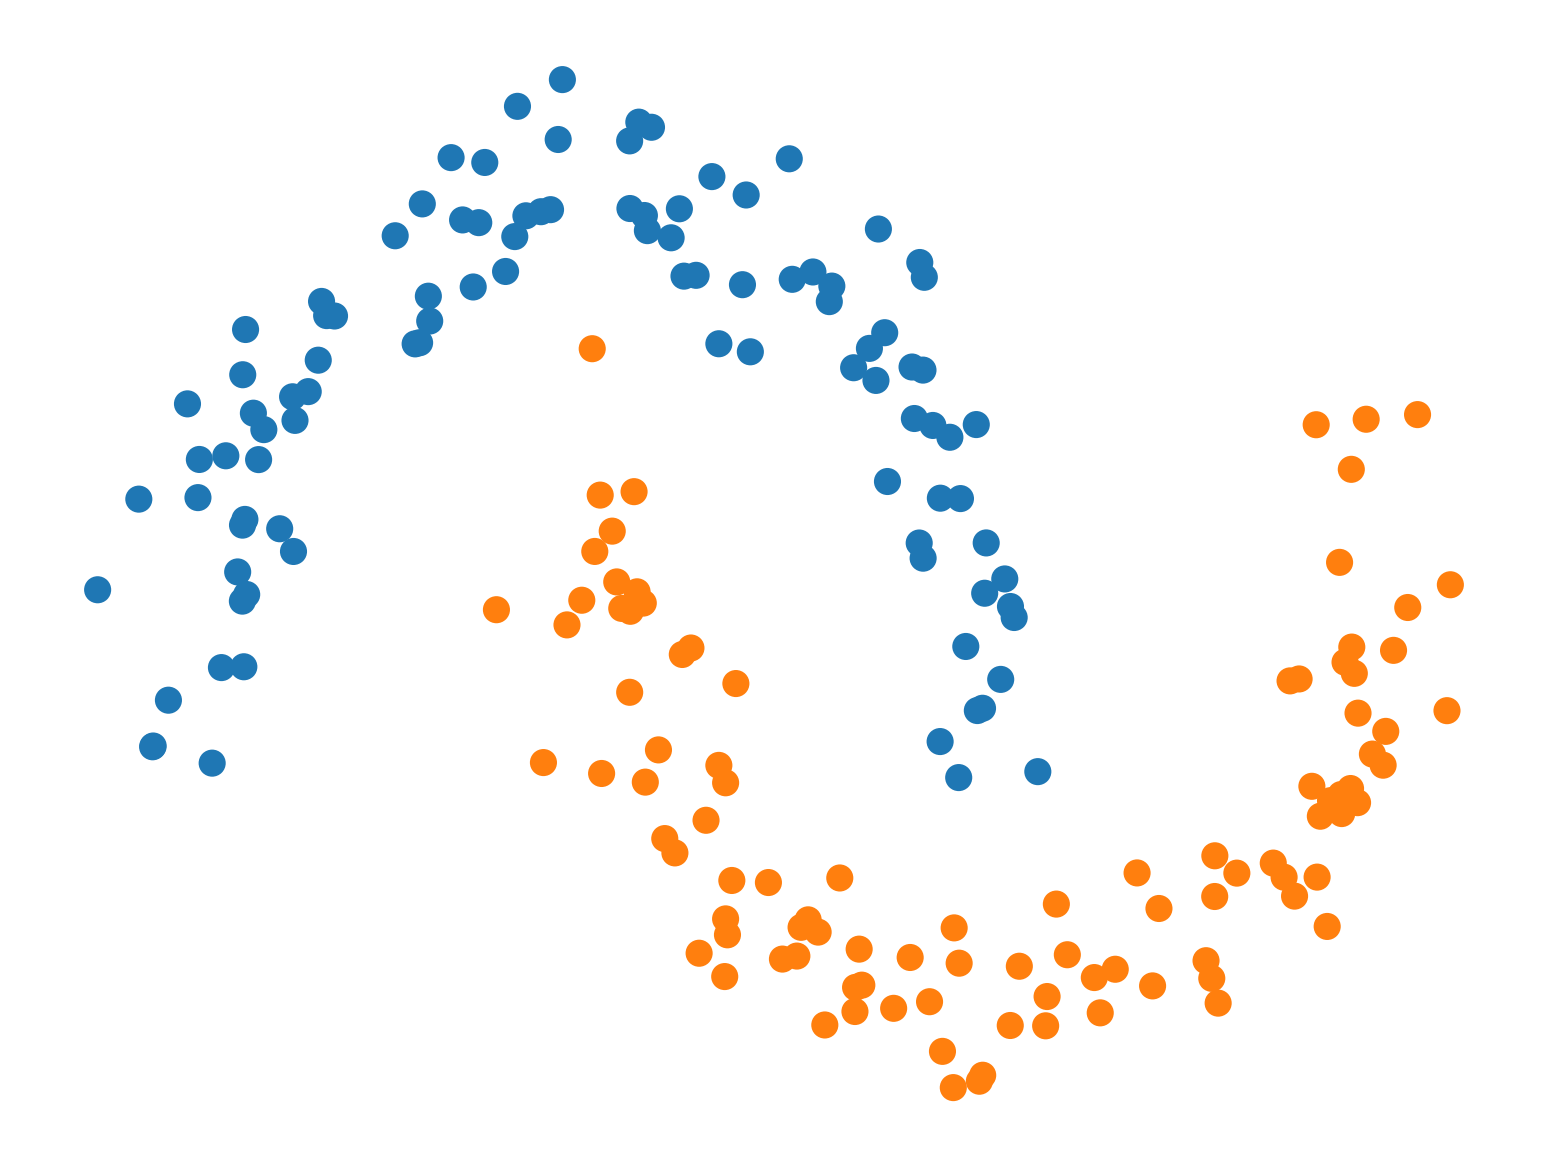

In [331]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

## 2. Defining the Quantum Neural Network

In [335]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [336]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

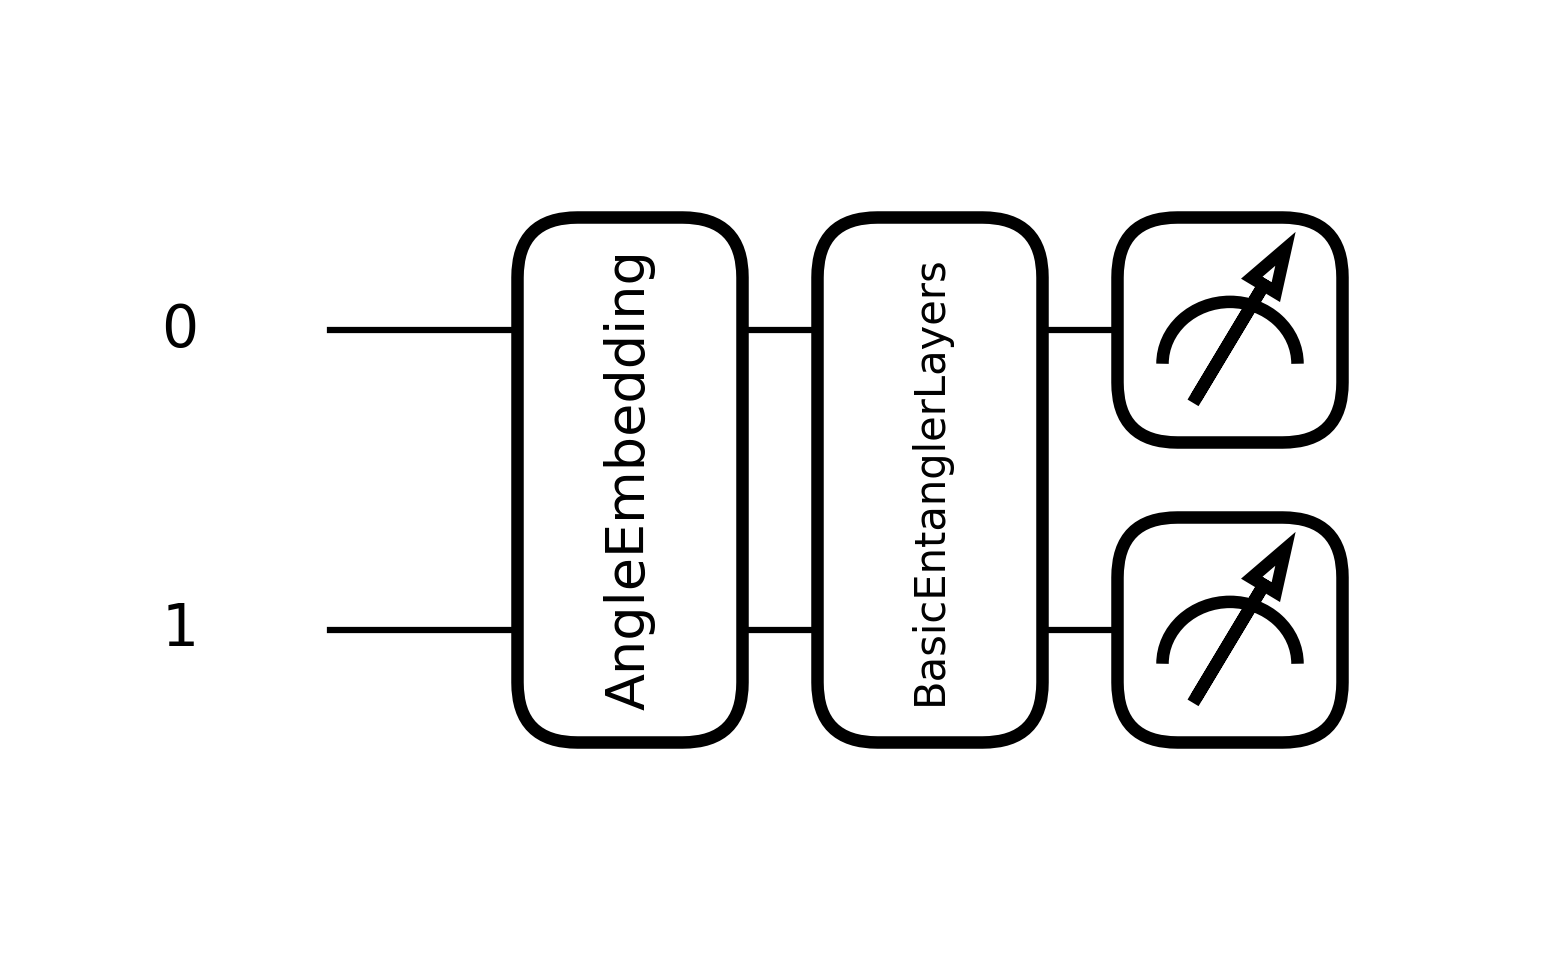

In [337]:
drawer = qml.draw(circuit)
plt.style.use("pennylane.drawer.plot")  # set pennylane theme, which is nice to see

params = np.array([[0.1, 0.3]])
weights = np.array([[np.pi/2, -np.pi/2]])

qml.draw_mpl(circuit, decimals=2,)(params, weights)

plt.show()

In [338]:
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)


## 3. Creating the Hybrid Neural Network Architecture

In [339]:
clayer_1 = torch.nn.Linear(2, 2)
clayer_2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)
layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

## 4. Model Training

In [340]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
loss = torch.nn.L1Loss()

In [341]:
X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

batch_size = 5
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

epochs = 6

for epoch in tqdm(range(epochs)):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

  0%|          | 0/6 [00:00<?, ?it/s]

Average loss over epoch 1: 0.4337
Average loss over epoch 2: 0.2627
Average loss over epoch 3: 0.1995
Average loss over epoch 4: 0.1787
Average loss over epoch 5: 0.1689
Average loss over epoch 6: 0.1606
Accuracy: 85.5%
